In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

## Вариант 1
#### Задание 1. 
Применим t-test и критерий Mann-Whitney для проверки данной гипотезы.

t-test и критерий Mann-Whitney не проверяют одни и те же гипотезы, t-test проверяет нулевую гипотезу о равных средний и альтернативную гипотезу - не равных средних. Нулевая гипотеза критерия Mann-Whitney - вероятность того, что случайное наблюдение из одной группы больше, чем случайное наблюдение из другой группы равна 0.5, а альтернативная - что не равна.

Обычно критерий Mann-Whitney исполюзуют для проверки гипотезы о равенстве распределений двух выборок, однако он реагирует только на то, как часто элемент одной выборки больше элемента другой выборки. В нашем случае, если две выборки распределены нормально с разными дисперсиями и одинаковыми средними, то критерий Mann-Whitney при достаточно большом n будет склоняться в пользу того, что нулевую гипотезу нельзя отвергнуть (хоть распределения и разные). То же самое сделает и t-test, так как его нулевая гипотеза о равенстве средних. В другом случае, если средние не равны, при достаточно большом n критерий Mann-Whitney отвергнет нулевую гипотезу, так как вероятность того, что элемент одной группы будет больше элемента другой группы сместиться от величины 0.5.

Это были мои попытки теоретически обосновать, почему критерии можно сравнивать в приминении к данной задаче. А теперь промоделируем.

##### Ошибка второго рода - это вероятность того, что у выборок разные средние, но принялась гипотеза H0

In [39]:
# следующая функция создает 2n выборок с заданными дисперсиями и средними,
# считает количество ошибок второго рода у критериев t-test и Mann-Whitney, усредняет их и выводит мощности 
def create_samples(a_1, a_2, d=0, n=250, p=0.05):
    samples_1, samples_2 = [], []
    for i in range(n):
        samples_1.append(np.random.normal(a_1, d, 1000))
        samples_2.append(np.random.normal(a_2, 1 + d, 1000))
    
    counter_ttest, counter_mw = 0, 0
    for sample_1, sample_2 in zip(samples_1, samples_2):
        p_value_mw = scipy.stats.mannwhitneyu(sample_1, sample_2, alternative="two-sided").pvalue
        p_value_ts = scipy.stats.ttest_ind(sample_1, sample_2, equal_var=False).pvalue
        
        counter_mw += p_value_mw > p
        counter_ttest += p_value_ts > p
    
    return (1 - counter_mw / n, 1 - counter_ttest/n)

In [40]:
# функция генерирует выборки с разными средними и дисперсией 1 и сохраняет мощности в массив для дальнейшей визуализации
def calculate(left, right, step, a=0, d=0):
    x, y_1, y_2 = [], [], []
    for diffrent in np.arange(left, right + step, step):
        x.append(diffrent)
        mw, ts = create_samples(a, a + diffrent, d=1)
        y_1.append(mw)
        y_2.append(ts)
    return (x, y_1, y_2)

На следующем графике видно, что тесты работают очень похоже, но t-test чуть более мощный:

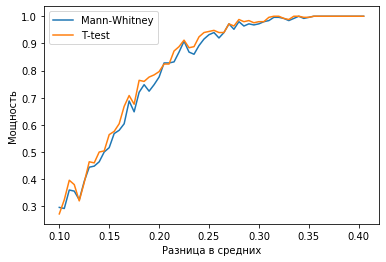

In [48]:
x, y_1, y_2 = calculate(0.1, 0.4, 0.005, d=1000)
fig, ax = plt.subplots()
plt.plot(x, y_1);
plt.plot(x, y_2);
plt.legend(['Mann-Whitney', 'T-test']);
ax.set_xlabel('Разница в средних');
ax.set_ylabel('Мощность');

Если произвести сглаживание, то станет более наглядно, что t-test более мощный:

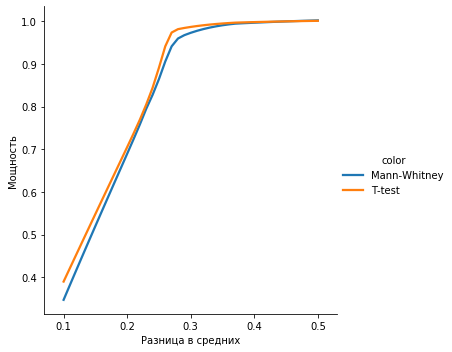

In [68]:
df_1 = pd.DataFrame({'x' : x, 'y' : y_1})
df_2 = pd.DataFrame({'x' : x, 'y' : y_2})
df = pd.concat([df_1, df_2])
df['color'] = ['Mann-Whitney'] * len(x) + ['T-test'] * len(x)
sns.lmplot(x='x',y='y',data=df, lowess=True, scatter=False, hue='color');
plt.xlabel('Разница в средних');
plt.ylabel('Мощность');

Теперь увеличим дисперсию до 1000, t-test по-прежднему более мощный:

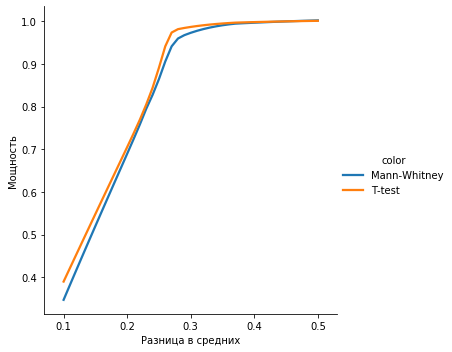

In [67]:
x, y_1, y_2 = calculate(0.1, 0.5, 0.01, d=1000)
df_1 = pd.DataFrame({'x' : x, 'y' : y_1})
df_2 = pd.DataFrame({'x' : x, 'y' : y_2})
df = pd.concat([df_1, df_2])
df['color'] = ['Mann-Whitney'] * len(x) + ['T-test'] * len(x)
sns.lmplot(x='x',y='y',data=df, lowess=True, scatter=False, hue='color');
plt.xlabel('Разница в средних');
plt.ylabel('Мощность');

Проверим, что t-тест работает корректно. Для этого сгенерируем две группы выборок, с одинаковыми средними и с разными и для каждой пары в каждой группе посчитаем p-value.

In [98]:
# разные дисперсии, равные средние
samples_1, samples_2, p_value_ts = [], [], []
for i in range(500):
    samples_1.append(np.random.normal(0, 1, 100))
    samples_2.append(np.random.normal(0, 2, 100))
for sample_1, sample_2 in zip(samples_1, samples_2):
    p_value_ts.append(scipy.stats.ttest_ind(sample_1, sample_2, equal_var=False).pvalue)

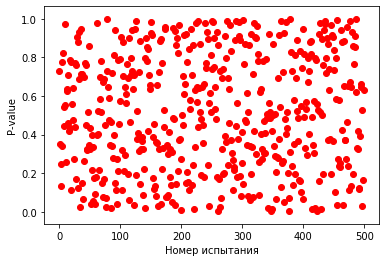

In [99]:
fig, ax = plt.subplots()
plt.scatter(x=[i for i in range(len(p_value_ts))], y=p_value_ts, c='r');
ax.set_xlabel('Номер испытания');
ax.set_ylabel('P-value');

Видно, что p-value распределен равномерно от 0 до 1, сгенерериуем теперь выборки c разными средними

In [86]:
# разные средние
samples_1, samples_2, p_value_ts = [], [], []
for i in range(100):
    samples_1.append(np.random.normal(0, 1, 100))
    samples_2.append(np.random.normal(0.5, 1, 100))
for sample_1, sample_2 in zip(samples_1, samples_2):
    p_value_ts.append(scipy.stats.ttest_ind(sample_1, sample_2, equal_var=False).pvalue)

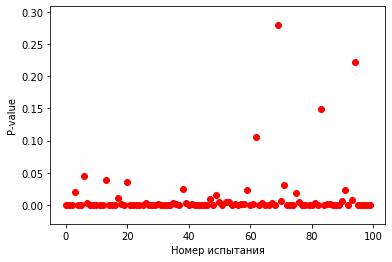

In [87]:
fig, ax = plt.subplots()
plt.scatter(x=[i for i in range(len(p_value_ts))], y=p_value_ts, c='r');
ax.set_xlabel('Номер испытания');
ax.set_ylabel('P-value');

Теперь видно, что p-value примерно в 5 случаев из 100 поднимается выше 0.05

Таким образом можно заключить, что критерий работает корректно

Проверим так же и критерий Mann-Witney:


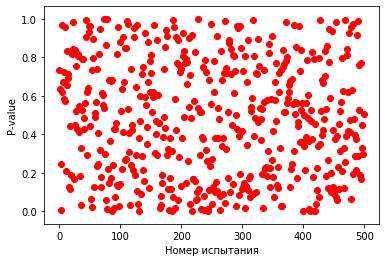

In [100]:
# разные дисперсии, равные средние
samples_1, samples_2, p_value = [], [], []
for i in range(500):
    samples_1.append(np.random.normal(0, 1, 100))
    samples_2.append(np.random.normal(0, 2, 100))
for sample_1, sample_2 in zip(samples_1, samples_2):
    p_value.append(scipy.stats.mannwhitneyu(sample_1, sample_2, alternative="two-sided").pvalue)
fig, ax = plt.subplots()
plt.scatter(x=[i for i in range(len(p_value))], y=p_value, c='r');
ax.set_xlabel('Номер испытания');
ax.set_ylabel('P-value');

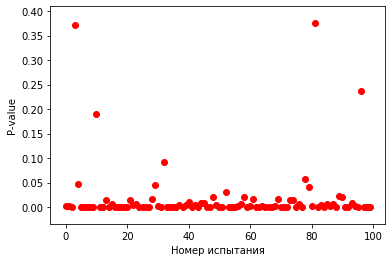

In [103]:
# разные средние
samples_1, samples_2, p_value = [], [], []
for i in range(100):
    samples_1.append(np.random.normal(0, 1, 100))
    samples_2.append(np.random.normal(0.5, 1, 100))
for sample_1, sample_2 in zip(samples_1, samples_2):
    p_value.append(scipy.stats.mannwhitneyu(sample_1, sample_2, alternative="two-sided").pvalue)
fig, ax = plt.subplots()
plt.scatter(x=[i for i in range(len(p_value))], y=p_value, c='r');
ax.set_xlabel('Номер испытания');
ax.set_ylabel('P-value');

Опять видно, что при одинаковых средних значение p-value достаточно равномерно, а при разных средних оно поднимается выше 0.05 примерно в 5% случаев.